In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+592.g7b21b40f1.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.12 GB available memory.


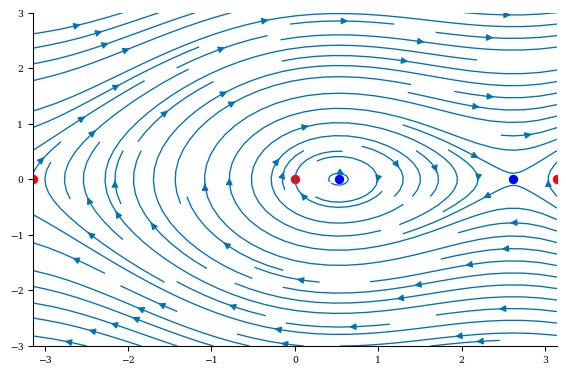

In [7]:
beta = 0.5
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)

x_dot = Y
y_dot = -np.sin(X) + beta
plt.streamplot(X, Y, x_dot, y_dot)
plt.scatter([-np.pi, 0, np.pi], [0, 0, 0], color="red")
plt.scatter([np.pi-np.arcsin(beta), np.arcsin(beta)], [0, 0], color="blue")

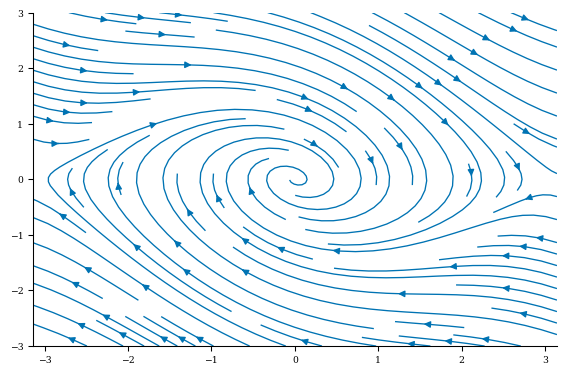

In [8]:
delta = 0.5
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)

x_dot = Y
y_dot = -np.sin(X) - delta * Y
plt.streamplot(X, Y, x_dot, y_dot)

In [18]:
from scipy.integrate import solve_ivp as sp_solve_ivp
from scipy.optimize import root as sp_root
import numpy as np

y0 = [np.pi, 0]
delta = 0.1
gamma = 0.1 
w = 1
T = 2*np.pi/w
t_span = (0, T)
fun = lambda t, y: [y[1], -np.sin(y[0]) - delta*y[1] + gamma*np.cos(w*t)]
p_map = lambda y: sp_solve_ivp(fun, t_span, y).y[:, -1]
fixed_point_error = lambda y: y - p_map(y)
sol = sp_root(fixed_point_error, y0)
sol.x

array([-0.4798,  0.634 ])

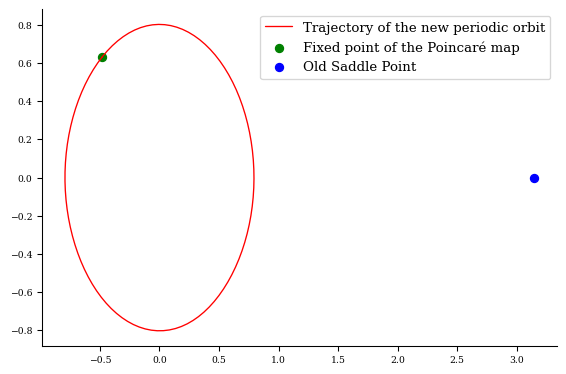

In [19]:
traj_periodic = sp_solve_ivp(
    fun, t_span, sol.x, t_eval=np.linspace(t_span[0], t_span[1], 100)
).y
plt.plot(
    traj_periodic[0],
    traj_periodic[1],
    color="red",
    label="Trajectory of the new periodic orbit",
)
traj_00 = sp_solve_ivp(
    fun,
    t_span,
    [np.pi, 0],
    t_eval=np.linspace(t_span[0], t_span[1], 100),
).y
plt.scatter(sol.x[0], sol.x[1], color="green", label="Fixed point of the Poincaré map")
plt.scatter(np.pi, 0, color="blue", label="Old Saddle Point")
plt.legend();

In [83]:
from scipy.integrate import solve_ivp as sp_solve_ivp
from scipy.optimize import root as sp_root
import numpy as np

# initial guess
y0 = [np.pi, 0]
w = 1
delta = 0.01
gamma = 4 / np.pi * delta * np.cosh(w * np.pi / 2) + delta * 0.1
gamma = 0.01
T = 2 * np.pi / w
fun = lambda t, y: [y[1], -np.sin(y[0]) - delta * y[1] + gamma * np.cos(w * t)]
p_map = lambda y: sp_solve_ivp(fun, (0, T), y, rtol=1e-9, atol=1e-9).y[:, -1]
p_map_bwd = lambda y: sp_solve_ivp(fun, (0, -T), y, rtol=1e-9, atol=1e-9).y[:, -1]
fixed_point_error = lambda y: y - p_map(y)
fixed_pt = sp_root(fixed_point_error, y0).x
# use finite differences to compute the Jacobian of the Poincare map
jacobian = np.zeros((2, 2))
epsilon = 1e-6
fxp = fixed_pt + np.array([epsilon, 0])
fxm = fixed_pt - np.array([epsilon, 0])
fyp = fixed_pt + np.array([0, epsilon])
fym = fixed_pt - np.array([0, epsilon])
jacobian[:, 0] = (p_map(fxp) - p_map(fxm)) / (2 * epsilon)
jacobian[:, 1] = (p_map(fyp) - p_map(fym)) / (2 * epsilon)
eigenvalues, eigenvectors = np.linalg.eig(jacobian)

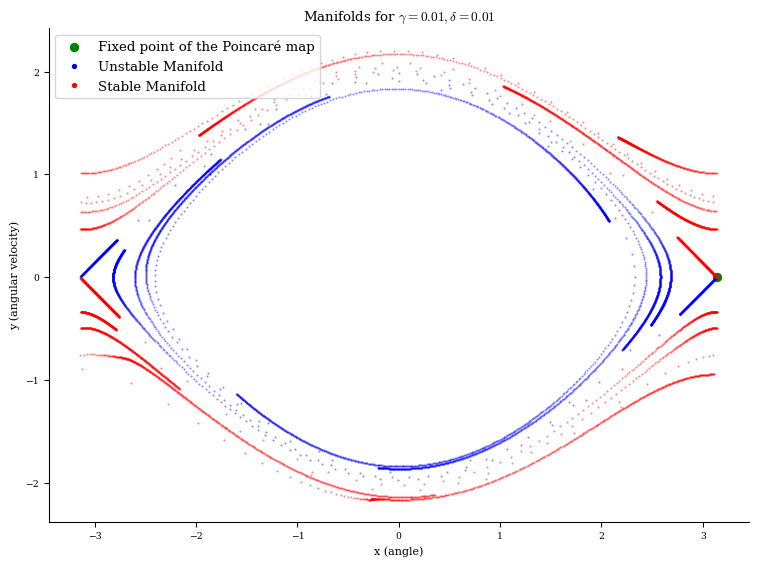

In [84]:
# select the stable and unstable eigenvectors based on the magnitude of the eigenvalues
if np.abs(eigenvalues[0]) < 1 and np.abs(eigenvalues[1]) > 1:
    stable_v = eigenvectors[:, 0]
    unstable_v = eigenvectors[:, 1]
if np.abs(eigenvalues[0]) > 1 and np.abs(eigenvalues[1]) < 1:
    stable_v = eigenvectors[:, 1]
    unstable_v = eigenvectors[:, 0]

plt.figure(figsize=(8, 6))
plt.scatter(
    fixed_pt[0], fixed_pt[1], color="green", label="Fixed point of the Poincaré map"
)

n_seeds = 1000  # Number of starting points along the eigenvector
n_iter = 5  # How many times to iterate the map
step_size = 1e-3

def find_manifold(fixed_pt, v, fig, fwd=True):
    for k in np.linspace(-step_size, step_size, n_seeds):
        if k == 0:
            continue
        pt = fixed_pt + k * v
        traj = [pt]
        for _ in range(n_iter):
            pt = p_map(pt) if fwd else p_map_bwd(pt)
            # Wrap x to [-pi, pi] for cylinder view
            pt_wrap = pt.copy()
            pt_wrap[0] = (pt_wrap[0] + np.pi) % (2 * np.pi) - np.pi
            traj.append(pt_wrap)

        traj = np.array(traj)
        m_type = "b." if fwd else "r."
        fig.plot(traj[:, 0], traj[:, 1], m_type, markersize=1, alpha=0.5)
    return fig

fig = find_manifold(fixed_pt, unstable_v, plt.gca(), fwd=True)
fig = find_manifold(fixed_pt, stable_v, plt.gca(), fwd=False)

# Add dummy plots for legend to avoid duplicate labels from loops
plt.plot([], [], "b.", label="Unstable Manifold")
plt.plot([], [], "r.", label="Stable Manifold")

plt.xlabel("x (angle)")
plt.ylabel("y (angular velocity)")
plt.title(f"Manifolds for $\\gamma={gamma}, \\delta={delta}$")
plt.legend();
plt.savefig(f"Manifolds for gamma={gamma}, delta={delta}.png", dpi=300)